# Group 33 - Proposal #

# Introduction

Diabetes is a health condition that affects how our bodies process nutrients into energy. Insulin plays a crucial role in this process, allowing the nutrients to enter our cells to be utilized. Diabetes is characterized as a difficulty with the amount or function of insulin, resulting in an abnormally high amount of sugar in the bloodstream. This can cause serious health problems, and so it is beneficial to predict in early stages.


Our study will predict the diabetes status of a patient, based on their medical profile. The Diabetes Prediction Dataset will be used to answer this question, which contains medical and demographical data such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. The data also includes diabetes status, with a 1 indicating the presence of diabetes, and a 0 indicating the absence of diabetes. These findings can be used to analyze the functionality of these predictors, developing our predictive models for diabetes status in the future.



# Preliminary Exploratory Data Analysis


## Reading and wrangling the data

In [64]:
library(tidyverse)
library(tidymodels)
library(gridExtra)

In [65]:
url <- "https://raw.githubusercontent.com/billiehbl/project_group33/main/diabetes_prediction_dataset.csv"
diabetes_data <- read_csv(url)

tidy_diabetes <- diabetes_data |> filter(smoking_history != "No Info") |> filter(gender != 'Other')|>
    filter(age >= 2)|> mutate(diabetes = as_factor(diabetes))

head(tidy_diabetes)

Rows: 100000 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, smoking_history
dbl (7): age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_l...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
Female,80,0,1,never,25.19,6.6,140,0
Male,28,0,0,never,27.32,5.7,158,0
Female,36,0,0,current,23.45,5.0,155,0
Male,76,1,1,current,20.14,4.8,155,0
Female,20,0,0,never,27.32,6.6,85,0
Female,44,0,0,never,19.31,6.5,200,1


## Splitting into testing and training data sets

In [66]:
diabetes_split <- initial_split(tidy_diabetes, prop = 0.75, strata = diabetes)
diabetes_train <- training(diabetes_split)
diabetes_train = diabetes_train[sample(1:nrow(diabetes_train)), ] # shuffles data frame
diabetes_testing <- testing(diabetes_split)

## Summary Statistics

In [67]:
training_counts <- diabetes_train |>
    group_by(diabetes) |>
    summarize(count = n())
training_counts

diabetes,count
<fct>,<int>
0,42724
1,5284


The above table shows the number of observations that fall into each category, diabetes absent and diabetes present, within the training data set. Here, there are significantly more observations that are diabetes absent compared to diabetes present, which reflects the smaller proportion of people in the general population who have diabetes.

In [68]:
means <- diabetes_train |>
        summarize(age = mean(age), bmi = mean(bmi),
        HbA1c = mean(HbA1c_level), blood_glucose = mean(blood_glucose_level))
tidy_means <- pivot_longer(means, cols = age:blood_glucose,
        names_to = "factor", values_to = "mean")

mins <- diabetes_train |>
        summarize(age = min(age), bmi = min(bmi),
        HbA1c = min(HbA1c_level), blood_glucose = min(blood_glucose_level))
tidy_mins <- pivot_longer(mins, cols = age:blood_glucose,
        names_to = "factor", values_to = "minimum")

max <- diabetes_train |>
        summarize(age = max(age), bmi = max(bmi),
        HbA1c = max(HbA1c_level), blood_glucose = max(blood_glucose_level))
tidy_max <- pivot_longer(max, cols = age:blood_glucose,
        names_to = "factor", values_to = "maximum")

summary <- tidy_means |>
        bind_cols(tidy_mins |> select(minimum)) |>
        bind_cols(tidy_max |> select(maximum))
summary

factor,mean,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>
age,46.578445,2.00,80.00
bmi,28.441515,10.08,88.76
HbA1c,5.564348,3.50,9.00
blood_glucose,139.604816,80.00,300.00


The above table provides summary statistics for each numeric predictor variable we will be using in our classifcation model based on the training data set.

## Visualizations

In [74]:
# Setting up data to plot.
ageToPlot = diabetes_train |> group_by(diabetes, age)|> summarize(num_age = n(), .groups = 'drop')
smokeToPlot = diabetes_train |> group_by(diabetes, smoking_history)|> summarize(num_smoke = n(), .groups = 'drop') |> 
            filter(smoking_history != 'ever')
glucToPlot = diabetes_train |> group_by(diabetes, blood_glucose_level)|> summarize(num_gluc = n(), .groups = 'drop')
hemoToPlot = diabetes_train |> group_by(diabetes, HbA1c_level)|> summarize(num_hemo = n(), .groups = 'drop')

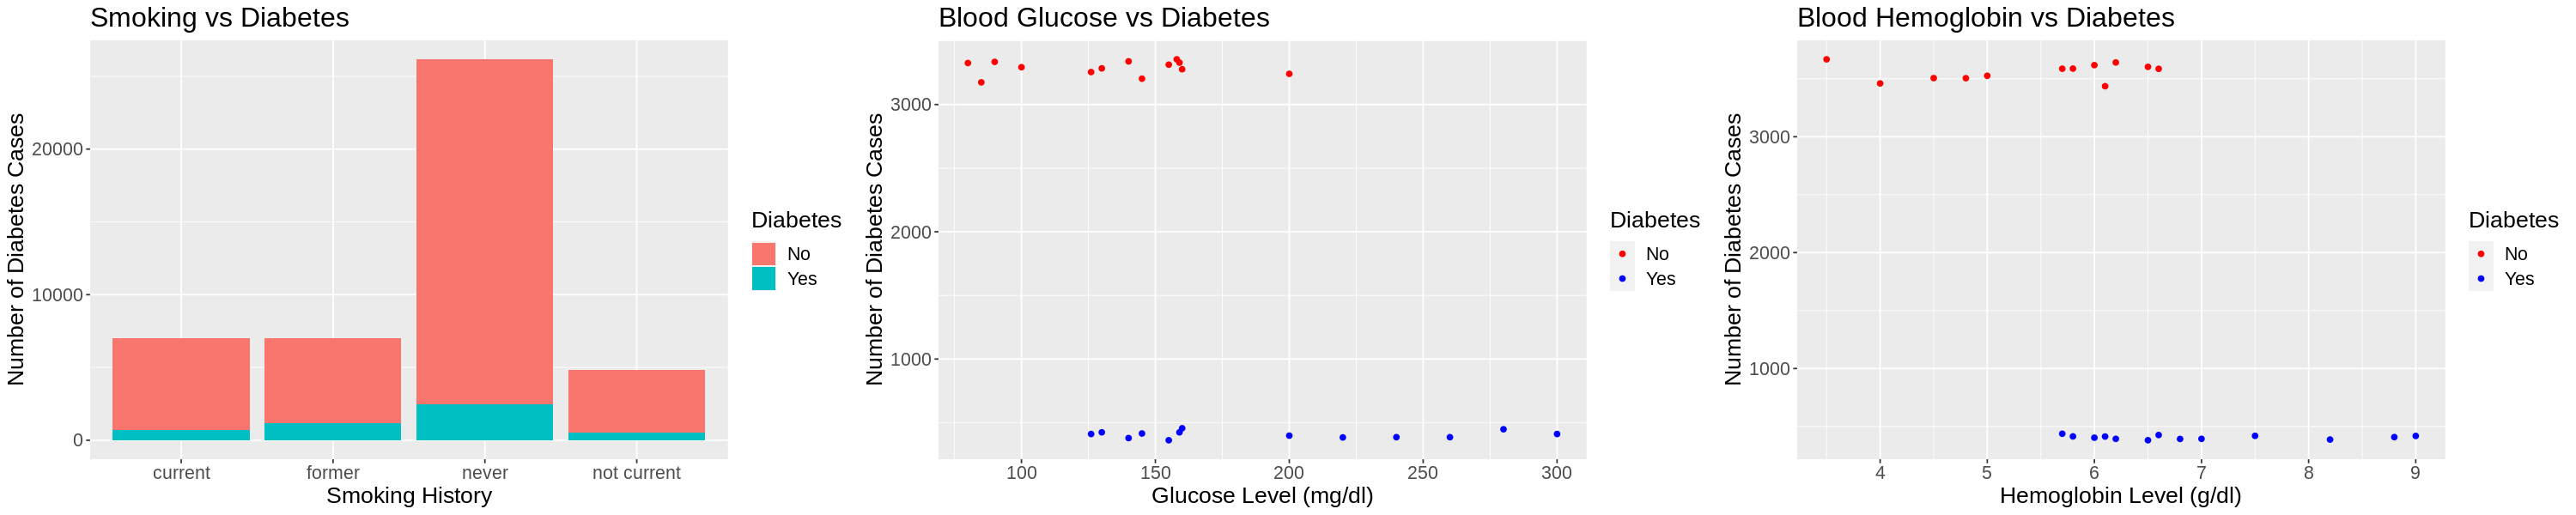

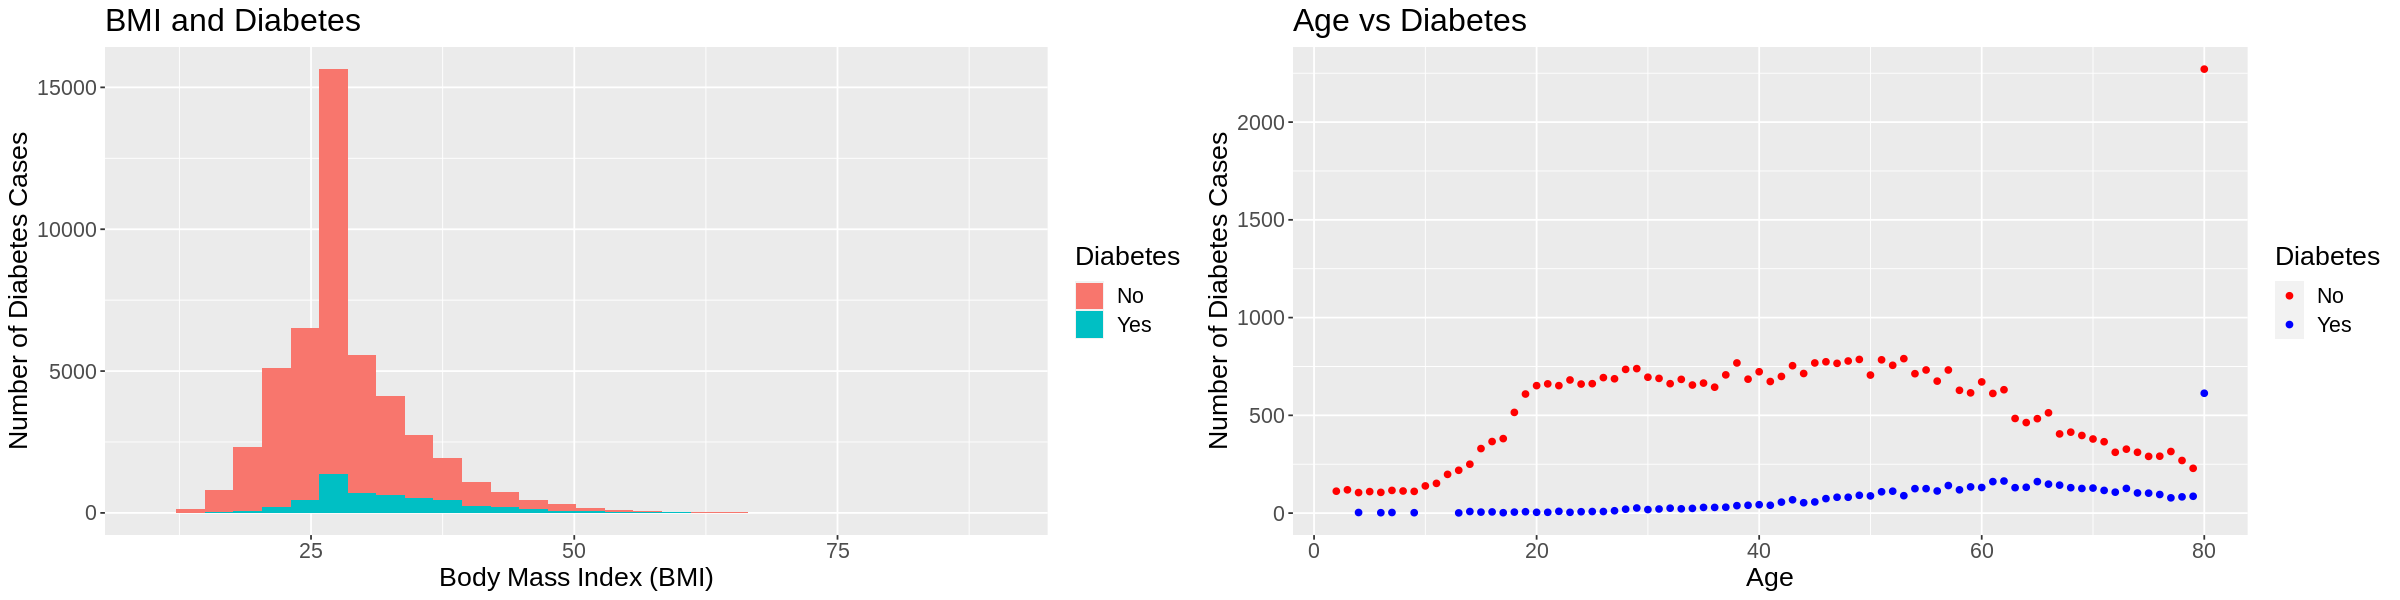

In [75]:
# Plots.
age_scatter = ggplot(ageToPlot, aes(x=age, y=num_age, color=diabetes)) + geom_point() + 
    labs(x='Age', y='Number of Diabetes Cases', title="Age vs Diabetes", color='Diabetes') + 
    scale_color_manual(labels = c("No", "Yes"), values = c("red", "blue")) +
    theme(text=element_text(size=16))

bmi_hist = ggplot(diabetes_train, aes(x = bmi, fill = diabetes)) + geom_histogram(bins=30) + 
    labs(x='Body Mass Index (BMI)', y='Number of Diabetes Cases', title="BMI and Diabetes") +
    scale_fill_discrete(name = "Diabetes", labels = c("No", "Yes")) +
    theme(text=element_text(size=16))

smoking_bar = ggplot(smokeToPlot, aes(x=smoking_history, y=num_smoke, fill=diabetes)) + geom_bar(stat = "identity") + 
    labs(x='Smoking History', y='Number of Diabetes Cases', title="Smoking vs Diabetes", color='Diabetes') + 
    scale_fill_discrete(name = "Diabetes", labels = c("No", "Yes")) +
    theme(text=element_text(size=16))

glucose_scatter = ggplot(glucToPlot, aes(x=blood_glucose_level, y=num_gluc, color=diabetes)) + geom_point() + 
    labs(x='Glucose Level (mg/dl)', y='Number of Diabetes Cases', 
         title="Blood Glucose vs Diabetes", color='Diabetes') + 
    scale_color_manual(labels = c("No", "Yes"), values = c("red", "blue")) +
    theme(text=element_text(size=16))

hemo_scatter = ggplot(hemoToPlot, aes(x=HbA1c_level, y=num_hemo, color=diabetes)) + geom_point() + 
    labs(x='Hemoglobin Level (g/dl)', y='Number of Diabetes Cases', 
         title="Blood Hemoglobin vs Diabetes", color='Diabetes') + 
    scale_color_manual(labels = c("No", "Yes"), values = c("red", "blue")) +
    theme(text=element_text(size=16))

options(repr.plot.width = 25, repr.plot.height = 5)
grid.arrange(smoking_bar, glucose_scatter, hemo_scatter, ncol=3)
options(repr.plot.width = 20, repr.plot.height = 5)
grid.arrange(bmi_hist, age_scatter, ncol=2)

# Methods

From the Diabetes Prediction Dataset, the predictors chosen for this study are age, BMI, HbA1c level, and blood glucose level. Both HbA1c levels and blood glucose levels are standard for predicting diabetes in patients, and higher levels are commonly used to diagnose and initiate treatment. Age is a crucial predictor because older age increases susceptibility to numerous health concerns, such as diabetes. Age will be constricted to 18 years of age and older. Diabetes generally increases body mass, as the body needs to consume more nutrients to get glucose into the cells when an insulin deficiency is a concern. As such, BMI is an ideal predictor and will be compared to all other predictors in the visualization of the data.

To visualize the data, scatter plots will be presented as 2500 randomly generated data points to prevent overplotting. BMI is plotted with each of the three predictors, creating a total of three plots. The data points will be colored in accordance with the diabetes diagnosis, either 'Not Diabetic' or 'Diabetic'. These predictors will then be used to train a classification model, and the accuracy of this model will be computed to assess the functionality of the specified predictors of diabetes.



# Expected Outcomes and Significance

**What do you expect to find?**

We expect to find that individuals who score highest in all of the predictor variables we will use for our classification model (age, bmi, HbA1c_level, blood_glucose_level) will be more likely to be diagnosed with diabetes compared to those who scored lower in these categories.

**What impact could such findings have?**

By analyzing these variables as a collective group, we can work towards developing predictive models, risk 
assessment tools, and interventions to identify the individuals who are at high risk for diabetes. Moreover, these findings can help healthcare professionals initiate prevention strategies, provide early 
interventions, and even improve diabetes management in affected individuals.

**What future questions could this lead to?**

Future questions this data can lead to is how do these variables interact with other factors such as 
genetic predispositions, socioeconomic status, or lifestyle factors, to impact the susceptibility of being
diagnosed with diabetes. Furthermore, this can lead to other future questions such as if we combine these variables with certain biomarkers or genetic markers it can enhance the early dectect of diabetes. Lastly, we have only shown how BMI and age interacts with diabetes in the graphs above; however, it would also be reasonable to have future questions regarding the relationship between all the different variables in the dataset and diabetes. For example, how does blood glucose levels correlate with diabetes diagnosis and risk assessment? How does smoking history influence the risk and progression of diabetes?